In [1]:
##### Copyright 2018 The TensorFlow Authors.

In [2]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# 使用 SavedModel 格式

<table class="tfo-notebook-buttons" align="left">
  <td><a target="_blank" href="https://tensorflow.google.cn/guide/saved_model" class=""><img src="https://tensorflow.google.cn/images/tf_logo_32px.png" class="">在 TensorFlow.org 上查看</a></td>
  <td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/zh-cn/guide/saved_model.ipynb"><img src="https://tensorflow.google.cn/images/colab_logo_32px.png">在 Google Colab 中运行</a></td>
  <td>     <a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/zh-cn/guide/saved_model.ipynb"><img src="https://tensorflow.google.cn/images/GitHub-Mark-32px.png">在 Github 上查看源代码</a>
</td>
  <td><a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/zh-cn/guide/saved_model.ipynb" class=""><img src="https://tensorflow.google.cn/images/download_logo_32px.png" class="">下载笔记本</a></td>
</table>

SavedModel 包含一个完整的 TensorFlow 程序，包括训练的参数（即 `tf.Variable`）和计算。它不需要原始模型构建代码就可以运行，因此，对于使用 [TFLite](https://tensorflow.org/lite)、[TensorFlow.js](https://js.tensorflow.org/)、[TensorFlow Serving](https://tensorflow.google.cn/tfx/serving/tutorials/Serving_REST_simple) 或 [TensorFlow Hub](https://tensorflow.org/hub) 共享或部署非常有用。

您可以使用以下 API 以 SavedModel 格式保存和加载模型：

- 低级 `tf.saved_model` API。本文档将详细介绍如何使用此 API。
    - 保存：`tf.saved_model.save(model, path_to_dir)`
    - 加载：`model = tf.saved_model.load(path_to_dir)`
- 高级`tf.keras.Model` API。请参阅 [Keras 保存和序列化指南](https://tensorflow.google.cn/guide/keras/save_and_serialize)。
- 如果您只是想在训练中保存/加载权重，请参阅[检查点指南](./checkpoint.ipynb)。

小心：TensorFlow 模型是代码，对于不受信任的代码，一定要小心。请参阅[安全使用 TensorFlow](https://github.com/tensorflow/tensorflow/blob/master/SECURITY.md) 以了解详情。


## 从 Keras 创建 SavedModel

已弃用：对于 Keras 对象，建议使用新的高级 `.keras` 格式和 `tf.keras.Model.export`，如[此处](https://tensorflow.google.cn/guide/keras/save_and_serialize)的指南所示。对于现有代码，继续支持低级 SavedModel 格式。

In [3]:
%cd ..
from set_env import temp_dir

/media/pc/data/lxw/ai/d2py/doc/libs/tf-chaos/guide


为便于简单介绍，本部分将导出一个预训练 Keras 模型来处理图像分类请求。本指南的其他部分将详细介绍和讨论创建 SavedModel 的其他方式。

In [4]:
import os
import tempfile

from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf

tmpdir = tempfile.mkdtemp(str(temp_dir))

In [5]:
physical_devices = tf.config.list_physical_devices('GPU')
for device in physical_devices:
  tf.config.experimental.set_memory_growth(device, True)

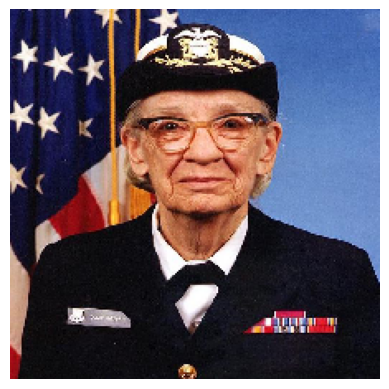

In [6]:
file = tf.keras.utils.get_file(
    "grace_hopper.jpg",
    "https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg")
img = tf.keras.utils.load_img(file, target_size=[224, 224])
plt.imshow(img)
plt.axis('off')
x = tf.keras.utils.img_to_array(img)
x = tf.keras.applications.mobilenet.preprocess_input(
    x[tf.newaxis,...])

我们会使用 Grace Hopper 的一张照片作为运行示例，并使用一个预先训练的 Keras 图像分类模型，因为它简单易用。您也可以使用自定义模型，后文会作详细介绍。

In [7]:
labels_path = tf.keras.utils.get_file(
    'ImageNetLabels.txt',
    'https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

In [8]:
pretrained_model = tf.keras.applications.MobileNet()
result_before_save = pretrained_model(x)

decoded = imagenet_labels[np.argsort(result_before_save)[0,::-1][:5]+1]

print("Result before saving:\n", decoded)

W0000 00:00:1729855602.693493 4125101 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729855602.717962 4125101 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729855602.718418 4125101 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729855602.740024 4125101 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729855602.740479 4125101 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729855602.740971 4125101 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729855602.751292 4125101 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729855602.751747 4125101 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729855602.753143 4125101 gp

Result before saving:
 ['military uniform' 'bow tie' 'suit' 'bearskin' 'pickelhaube']


对此图像的热门预测是“军服”。

In [9]:
mobilenet_save_path = os.path.join(tmpdir, "mobilenet/1/")
tf.saved_model.save(pretrained_model, mobilenet_save_path)

TypeError: this __dict__ descriptor does not support '_DictWrapper' objects

保存路径遵循 TensorFlow Serving 使用的惯例，路径的最后一个部分（此处为 `1/`）是模型的版本号：它可以让 Tensorflow Serving 之类的工具推断相对新鲜度。

您可以使用 `tf.saved_model.load` 将 SavedModel 加载回 Python，并查看 Admiral Hopper 的图像是如何分类的。

In [ ]:
loaded = tf.saved_model.load(mobilenet_save_path)
print(list(loaded.signatures.keys()))  # ["serving_default"]

导入的签名总是会返回字典。要自定义签名名称和输出字典键，请参阅[在导出过程中指定签名](#specifying_signatures_during_export)。

In [ ]:
infer = loaded.signatures["serving_default"]
print(infer.structured_outputs)

从 SavedModel 运行推断会产生与原始模型相同的结果。

In [ ]:
labeling = infer(tf.constant(x))[pretrained_model.output_names[0]]

decoded = imagenet_labels[np.argsort(labeling)[0,::-1][:5]+1]

print("Result after saving and loading:\n", decoded)

## 在 TensorFlow Serving 中运行 SavedModel

可以通过 Python 使用 SavedModel（下文中有详细介绍），但是，生产环境通常会使用专门服务进行推断，而不会运行 Python 代码。使用 TensorFlow Serving 时，这很容易从 SavedModel 进行设置。

请参阅 [TensorFlow Serving REST 教程](https://tensorflow.google.cn/tfx/tutorials/serving/rest_simple)了解端到端 tensorflow-serving 示例。

## 磁盘上的 SavedModel 格式

SavedModel 是一个包含序列化签名和运行这些签名所需的状态的目录，其中包括变量值和词汇。


In [ ]:
!ls {mobilenet_save_path}

`saved_model.pb` 文件用于存储实际 TensorFlow 程序或模型，以及一组已命名的签名，每个签名标识一个接受张量输入和产生张量输出的函数。

SavedModel 可能包含模型的多个变体（多个 `v1.MetaGraphDefs`，通过 `saved_model_cli` 的 `--tag_set` 标志进行标识），但这种情况很少见。可以为模型创建多个变体的 API 包括 [`tf.Estimator.experimental_export_all_saved_models`](https://tensorflow.google.cn/api_docs/python/tf/estimator/Estimator#experimental_export_all_saved_models) 和 TensorFlow 1.x 中的 `tf.saved_model.Builder`。

In [ ]:
!saved_model_cli show --dir {mobilenet_save_path} --tag_set serve

`variables` 目录包含一个标准训练检查点（参阅[训练检查点指南](./checkpoint.ipynb)）。

In [ ]:
!ls {mobilenet_save_path}/variables

`assets` 目录包含 TensorFlow 计算图使用的文件，例如，用于初始化词汇表的文本文件。本例中没有使用这种文件。

SavedModel 可能有一个用于保存 TensorFlow 计算图未使用的任何文件的 `assets.extra` 目录，例如，为使用者提供的关于如何处理 SavedModel 的信息。TensorFlow 本身并不会使用此目录。

`fingerprint.pb` 文件包含 SavedModel 的[指纹](https://en.wikipedia.org/wiki/Fingerprint_(computing))，它由几个 64 位哈希组成，以唯一的方式标识 SavedModel 的内容。指纹 API 目前处于实验阶段，但 `tf.saved_model.experimental.read_fingerprint` 可以用于将 SavedModel 指纹读取到 `tf.saved_model.experimental.Fingerprint` 对象中。

## 保存自定义模型

`tf.saved_model.save` 支持保存 `tf.Module` 对象及其子类，如 `tf.keras.Layer` 和 `tf.keras.Model`。

我们来看一个保存和恢复 `tf.Module` 的示例。


In [ ]:
class CustomModule(tf.Module):

  def __init__(self):
    super(CustomModule, self).__init__()
    self.v = tf.Variable(1.)

  @tf.function
  def __call__(self, x):
    print('Tracing with', x)
    return x * self.v

  @tf.function(input_signature=[tf.TensorSpec([], tf.float32)])
  def mutate(self, new_v):
    self.v.assign(new_v)

module = CustomModule()

当您保存 `tf.Module` 时，任何 `tf.Variable` 特性、`tf.function` 装饰的方法以及通过递归遍历找到的 `tf.Module` 都会得到保存。（参阅[检查点教程](./checkpoint.ipynb)，了解此递归遍历的详细信息。）但是，所有 Python 特性、函数和数据都会丢失。也就是说，当您保存 `tf.function` 时，不会保存 Python 代码。

如果不保存 Python 代码，SavedModel 如何知道怎样恢复函数？

简单地说，`tf.function` 的工作原理是，通过跟踪 Python 代码来生成 ConcreteFunction（一个可调用的 `tf.Graph` 封装容器）。当您保存 `tf.function` 时，实际上保存的是 `tf.function` 的 ConcreteFunction 缓存。

要详细了解 `tf.function` 与 ConcreteFunction 之间的关系，请参阅 [tf.function 指南](function.ipynb)。

In [ ]:
module_no_signatures_path = os.path.join(tmpdir, 'module_no_signatures')
module(tf.constant(0.))
print('Saving model...')
tf.saved_model.save(module, module_no_signatures_path)

## 加载和使用自定义模型

在 Python 中加载 SavedModel 时，所有 `tf.Variable` 特性、`tf.function` 装饰方法和 `tf.Module` 都会按照与原始保存的 `tf.Module` 相同的对象结构进行恢复。

In [ ]:
imported = tf.saved_model.load(module_no_signatures_path)
assert imported(tf.constant(3.)).numpy() == 3
imported.mutate(tf.constant(2.))
assert imported(tf.constant(3.)).numpy() == 6

由于没有保存 Python 代码，所以使用新输入签名调用 `tf.function` 会失败：

```python
imported(tf.constant([3.]))
```

<pre>ValueError: Could not find matching function to call for canonicalized inputs ((&lt;tf.Tensor 'args_0:0' shape=(1,) dtype=float32&gt;,), {}). Only existing signatures are [((TensorSpec(shape=(), dtype=tf.float32, name=u'x'),), {})].
</pre>

### 基本微调

可以使用变量对象，还可以通过导入的函数向后传播。对于简单情形，这足以支持 SavedModel 的微调（即重新训练）。

In [ ]:
optimizer = tf.keras.optimizers.SGD(0.05)

def train_step():
  with tf.GradientTape() as tape:
    loss = (10. - imported(tf.constant(2.))) ** 2
  variables = tape.watched_variables()
  grads = tape.gradient(loss, variables)
  optimizer.apply_gradients(zip(grads, variables))
  return loss

In [ ]:
for _ in range(10):
  # "v" approaches 5, "loss" approaches 0
  print("loss={:.2f} v={:.2f}".format(train_step(), imported.v.numpy()))

### 一般微调

与普通 `__call__` 相比，Keras 的 SavedModel 提供了[更多详细信息](https://github.com/tensorflow/community/blob/master/rfcs/20190509-keras-saved-model.md#serialization-details)来解决更复杂的微调情形。TensorFlow Hub 建议在共享的 SavedModel 中提供以下详细信息（如果适用），以便进行微调：

- 如果模型使用随机失活，或者是训练与推断之间的前向传递不同的另一种技术（如批次归一化），则 `__call__` 方法会获取一个可选的 Python 值 `training=` 参数。该参数的默认值为 `False`，但可将其设置为 `True`。
- 对于变量的对应列表，除了 `__call__` 特性，还有 `.variable` 和 `.trainable_variable` 特性。在微调过程中，`.trainable_variables` 省略了一个变量，该变量原本可训练，但打算将其冻结。
- 对于 Keras 等将权重正则化项表示为层或子模型特性的框架，还有一个 `.regularization_losses` 特性。它包含一个零参数函数的列表，这些函数的值应加到总损失中。

回到初始 MobileNet 示例，您可以看到一些具体操作：

In [ ]:
loaded = tf.saved_model.load(mobilenet_save_path)
print("MobileNet has {} trainable variables: {}, ...".format(
          len(loaded.trainable_variables),
          ", ".join([v.name for v in loaded.trainable_variables[:5]])))

In [ ]:
trainable_variable_ids = {id(v) for v in loaded.trainable_variables}
non_trainable_variables = [v for v in loaded.variables
                           if id(v) not in trainable_variable_ids]
print("MobileNet also has {} non-trainable variables: {}, ...".format(
          len(non_trainable_variables),
          ", ".join([v.name for v in non_trainable_variables[:3]])))

## 导出时指定签名

TensorFlow Serving 之类的工具和 `saved_model_cli` 可以与 SavedModel 交互。为了帮助这些工具确定要使用的 ConcreteFunction，我们需要指定应用签名。`tf.keras.Model` 会自动指定应用签名，但是，对于自定义模块，我们必须明确声明应用签名。

重要提示：除非您需要使用 Python 将模型导出到 TensorFlow 2.x 之外的环境，否则您不需要明确导出签名。如果您在寻找为特定函数强制输入签名的方式，请参阅 `tf.function` 的 [`input_signature`](https://tensorflow.google.cn/api_docs/python/tf/function#args_1) 参数。

默认情况下，自定义 `tf.Module` 中不会声明签名。

In [ ]:
assert len(imported.signatures) == 0

要声明应用签名，请使用 `signatures` 关键字参数指定 ConcreteFunction。指定单个签名时，签名键为 `'serving_default'`，并将保存为常量 `tf.saved_model.DEFAULT_SERVING_SIGNATURE_DEF_KEY`。

In [ ]:
module_with_signature_path = os.path.join(tmpdir, 'module_with_signature')
call = module.__call__.get_concrete_function(tf.TensorSpec(None, tf.float32))
tf.saved_model.save(module, module_with_signature_path, signatures=call)

In [ ]:
imported_with_signatures = tf.saved_model.load(module_with_signature_path)
list(imported_with_signatures.signatures.keys())


要导出多个签名，请将签名键的字典传递给 ConcreteFunction。每个签名键对应一个 ConcreteFunction。

In [ ]:
module_multiple_signatures_path = os.path.join(tmpdir, 'module_with_multiple_signatures')
signatures = {"serving_default": call,
              "array_input": module.__call__.get_concrete_function(tf.TensorSpec([None], tf.float32))}

tf.saved_model.save(module, module_multiple_signatures_path, signatures=signatures)

In [ ]:
imported_with_multiple_signatures = tf.saved_model.load(module_multiple_signatures_path)
list(imported_with_multiple_signatures.signatures.keys())

默认情况下，输出张量名称非常通用，如 `output_0`。为了控制输出的名称，请修改 `tf.function`，以便返回将输出名称映射到输出的字典。输入的名称来自 Python 函数参数名称。

In [ ]:
class CustomModuleWithOutputName(tf.Module):
  def __init__(self):
    super(CustomModuleWithOutputName, self).__init__()
    self.v = tf.Variable(1.)

  @tf.function(input_signature=[tf.TensorSpec(None, tf.float32)])
  def __call__(self, x):
    return {'custom_output_name': x * self.v}

module_output = CustomModuleWithOutputName()
call_output = module_output.__call__.get_concrete_function(tf.TensorSpec(None, tf.float32))
module_output_path = os.path.join(tmpdir, 'module_with_output_name')
tf.saved_model.save(module_output, module_output_path,
                    signatures={'serving_default': call_output})

In [ ]:
imported_with_output_name = tf.saved_model.load(module_output_path)
imported_with_output_name.signatures['serving_default'].structured_outputs

## proto 分割

注：此功能将成为 TensorFlow 2.15 版本的一部分。它目前在 Nightly 版本中提供，您可以使用 `pip install tf-nightly` 进行安装。

由于 protobuf 实现的限制，proto 的大小不能超过 2GB。在尝试保存非常大的模型时，这可能会导致以下错误：

```
ValueError: Message tensorflow.SavedModel exceeds maximum protobuf size of 2GB: ...
```

```
google.protobuf.message.DecodeError: Error parsing message as the message exceeded the protobuf limit with type 'tensorflow.GraphDef'
```

如果您希望保存超过 2GB 限制的模型，则需要使用新的 proto 分割选项进行保存：

```python
tf.saved_model.save(
  ...,
  options=tf.saved_model.SaveOptions(experimental_image_format=True)
)
```

更多信息，请参阅 [Proto 分割器/合并器库指南](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/tools/proto_splitter/in-depth-guide.md)。

## 在 C++ 中加载  SavedModel

SavedModel [加载器](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/cc/saved_model/loader.h)的 C++ 版本提供了一个从路径中加载 SavedModel 的 API，同时允许使用 SessionOption 和 RunOption。您必须指定与计算图相关联的标记才能加载模型。加载的 SavedModel 版本称为 SavedModelBundle，其中包含 MetaGraphDef 以及加载该版本所处的会话。

```C++
const string export_dir = ...
SavedModelBundle bundle;
...
LoadSavedModel(session_options, run_options, export_dir, {kSavedModelTagTrain},
               &amp;bundle);
```

<a id="saved_model_cli"></a>

## SavedModel 命令行接口详细信息

您可以使用 SavedModel 命令行接口 (CLI) 检查和执行 SavedModel。例如，您可以使用 CLI 来检查模型的 `SignatureDef`。通过 CLI，您可以快速确认与模型相符的输入张量的 dtype 和形状。此外，如果要测试模型，您可以传入各种格式的样本输入（例如，Python 表达式），然后获取输出，使用 CLI 执行健全性检查。

### 安装 SavedModel CLI

一般来说，通过以下两种方式都可以安装 TensorFlow：

- 安装预构建的 TensorFlow 二进制文件。
- 从源代码构建 TensorFlow。

如果您是通过预构建的 TensorFlow 二进制文件安装的 TensorFlow，则 SavedModel CLI 已安装到您的系统上，路径为 `bin/saved_model_cli`。

如果是从源代码构建的 TensorFlow，则还必须运行以下附加命令才能构建 `saved_model_cli`：

```
$ bazel build //tensorflow/python/tools:saved_model_cli
```

### 命令概述

SavedModel CLI 支持在 SavedModel 上使用以下两个命令：

- `show`：用于显示 SavedModel 中可用的计算。
- `run`：用于从 SavedModel 运行计算。

### `show` 命令

SavedModel 包含一个或多个模型变体（从技术上说，为 `v1.MetaGraphDef`），这些变体通过 tag-set 进行标识。要应用模型，您可能想知道每个模型变体中使用的具体是哪一种 `SignatureDef` ，以及它们的输入和输出是什么。那么，利用 `show` 命令，您就可以按照层级顺序检查 SavedModel 的内容。具体语法如下：

```
usage: saved_model_cli show [-h] --dir DIR [--all]
[--tag_set TAG_SET] [--signature_def SIGNATURE_DEF_KEY]
```

例如，以下命令会显示 SavedModel 中的所有可用 tag-set：

```
$ saved_model_cli show --dir /tmp/saved_model_dir
The given SavedModel contains the following tag-sets:
serve
serve, gpu
```

以下命令会显示 tag-set 的所有可用 `SignatureDef` 键：

```
$ saved_model_cli show --dir /tmp/saved_model_dir --tag_set serve The given SavedModel `MetaGraphDef` contains `SignatureDefs` with the following keys: SignatureDef key: "classify_x2_to_y3" SignatureDef key: "classify_x_to_y" SignatureDef key: "regress_x2_to_y3" SignatureDef key: "regress_x_to_y" SignatureDef key: "regress_x_to_y2" SignatureDef key: "serving_default"
```

如果 tag-set 中有*多个*标记，则必须指定所有标记（标记之间用逗号分隔）。例如：

<pre>$ saved_model_cli show --dir /tmp/saved_model_dir --tag_set serve,gpu</pre>

要显示特定 `SignatureDef` 的所有输入和输出 TensorInfo，请将 `SignatureDef` 键传递给 `signature_def` 选项。如果您想知道输入张量的张量键值、dtype 和形状，以便随后执行计算图，这会非常有用。例如：

```
$ saved_model_cli show --dir \ /tmp/saved_model_dir --tag_set serve --signature_def serving_default The given SavedModel SignatureDef contains the following input(s):   inputs['x'] tensor_info:       dtype: DT_FLOAT       shape: (-1, 1)       name: x:0 The given SavedModel SignatureDef contains the following output(s):   outputs['y'] tensor_info:       dtype: DT_FLOAT       shape: (-1, 1)       name: y:0 Method name is: tensorflow/serving/predict
```

要显示 SavedModel 中的所有可用信息，请使用 `--all` 选项。例如：

<pre>$ saved_model_cli show --dir /tmp/saved_model_dir --all&lt;br&gt;MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:&lt;br&gt;&lt;br&gt;signature_def['classify_x2_to_y3']:&lt;br&gt;  The given SavedModel SignatureDef contains the following input(s):&lt;br&gt;    inputs['inputs'] tensor_info:&lt;br&gt;        dtype: DT_FLOAT&lt;br&gt;        shape: (-1, 1)&lt;br&gt;        name: x2:0&lt;br&gt;  The given SavedModel SignatureDef contains the following output(s):&lt;br&gt;    outputs['scores'] tensor_info:&lt;br&gt;        dtype: DT_FLOAT&lt;br&gt;        shape: (-1, 1)&lt;br&gt;        name: y3:0&lt;br&gt;  Method name is: tensorflow/serving/classify&lt;br&gt;&lt;br&gt;...&lt;br&gt;&lt;br&gt;signature_def['serving_default']:&lt;br&gt;  The given SavedModel SignatureDef contains the following input(s):&lt;br&gt;    inputs['x'] tensor_info:&lt;br&gt;        dtype: DT_FLOAT&lt;br&gt;        shape: (-1, 1)&lt;br&gt;        name: x:0&lt;br&gt;  The given SavedModel SignatureDef contains the following output(s):&lt;br&gt;    outputs['y'] tensor_info:&lt;br&gt;        dtype: DT_FLOAT&lt;br&gt;        shape: (-1, 1)&lt;br&gt;        name: y:0&lt;br&gt;  Method name is: tensorflow/serving/predict</pre>

### `run` 命令

调用 `run` 命令即可运行计算图计算，传递输入，然后显示输出，还可以选择保存。具体语法如下：

```
usage: saved_model_cli run [-h] --dir DIR --tag_set TAG_SET --signature_def
                           SIGNATURE_DEF_KEY [--inputs INPUTS]
                           [--input_exprs INPUT_EXPRS]
                           [--input_examples INPUT_EXAMPLES] [--outdir OUTDIR]
                           [--overwrite] [--tf_debug]
```

要将输入传递给模型，`run` 命令提供了以下三种方式：

- `--inputs` 选项：可传递文件中的 NumPy ndarray。
- `--input_exprs` 选项：可传递 Python 表达式。
- `--input_examples` 选项：可传递 `tf.train.Example`。

#### `--inputs`

要传递文件中的输入数据，请指定 `--inputs` 选项，一般格式如下：

```bsh
--inputs <INPUTS>
```

其中，*INPUTS* 采用以下格式之一：

- `<input_key>=<filename>`
- `<input_key>=<filename>[<variable_name>]`

您可以传递多个 *INPUTS*。如果确实要传递多个输入，请使用分号分隔每个 *INPUTS*。

`saved_model_cli` 使用 `numpy.load` 来加载 *filename*。*filename* 可能为以下任何格式：

- `.npy`
- `.npz`
- pickle 格式

`.npy` 文件始终包含一个 NumPy ndarray。因此，从 `.npy` 文件加载时，会将内容直接分配给指定的输入张量。如果使用 `.npy` 文件来指定 *variable_name*，则会忽略 *variable_name*，并且会发出警告。

从 `.npz` (zip) 文件加载时，您可以选择指定 *variable_name*，以便标识 zip 文件中要为输入张量键加载的变量。如果不指定 *variable_name*，SavedModel CLI 会检查 zip 文件中是否只包含一个文件。如果是，则为指定的输入张量键加载该文件。

从 pickle 文件加载时，如果未在方括号中指定 `variable_name`，则会将该 pickle 文件中的任何内容全部传递给指定的输入张量键。否则，SavedModel CLI 会假设该 pickle 文件中有一个字典，并将使用与 *variable_name* 对应的值。

#### `--input_exprs`

要通过 Python 表达式传递输入，请指定 `--input_exprs` 选项。当您没有现成的数据文件，而又想使用与模型的 `SignatureDef` 的 dtype 和形状相符的一些简单输入来对模型进行健全性检查时，这非常有用。例如：

```bsh
`<input_key>=[[1],[2],[3]]`
```

除了 Python 表达式，您还可以传递 NumPy 函数。例如：

```bsh
`<input_key>=np.ones((32,32,3))`
```

（请注意，`numpy` 模块已作为 `np` 提供。）

#### `--input_examples`

要传递 `tf.train.Example` 作为输入，请指定 `--input_examples` 选项。对于每个输入键，它会获取一个字典列表，其中每个字典是 `tf.train.Example` 的一个实例。字典键就是特征，而值则是每个特征的值列表。例如：

```bsh
`<input_key>=[{"age":[22,24],"education":["BS","MS"]}]`
```

#### 保存输出

默认情况下，SavedModel CLI 会将输出写入 stdout。如果将字典传递给 `--outdir` 选项，则会将输出保存为以给定字典下的输出张量键命名的 `.npy` 文件。

使用 `--overwrite` 可重写现有输出文件。
